# Stackoverflow data

## Init

### Imports

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from hd_utils import monitor
from nltk.corpus import stopwords
from html.parser import HTMLParser
from sklearn.datasets.lfw import Bunch
from html_preprocessing import HTMLPreprocessor

### Plot

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

### Args

In [4]:
args = Bunch()

## Read

In [5]:
args.data_kaggle_name = 'pythonquestions'
args.len_up = 7500

In [6]:
!pip install kaggle
!kaggle datasets download -d stackoverflow/$args.data_kaggle_name

pythonquestions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
_base_path = f'~/.kaggle/datasets/stackoverflow/{args.data_kaggle_name}'
questions_path = os.path.join(_base_path, 'Questions.csv')
tags_path = os.path.join(_base_path, 'Tags.csv')

In [8]:
%time qdf = pd.read_csv(questions_path, encoding='ISO-8859-1')
qdf.shape

CPU times: user 10.5 s, sys: 1.08 s, total: 11.6 s
Wall time: 12.8 s


(607282, 6)

In [9]:
qdf.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [10]:
qdf.drop(['OwnerUserId', 'CreationDate', 'Score'], axis=1, inplace=True)
qdf.rename({c: c.lower() for c in qdf.columns}, axis=1, inplace=True)
qdf.shape

(607282, 3)

In [11]:
qdf.head()

,id,title,body
0,469,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


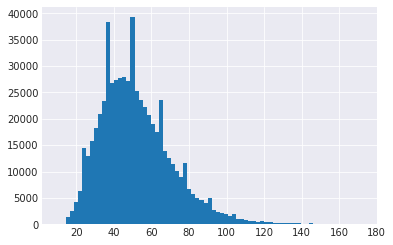

In [12]:
qdf.title.map(len).hist(bins=75);

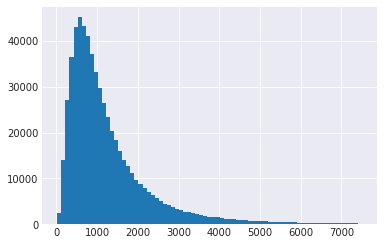

In [13]:
body_lens = qdf.body.map(len)
body_lens = body_lens[body_lens <= args.len_up]
body_lens.hist(bins=75);

## Text

In [14]:
args.log_step = 5000

In [15]:
sample = qdf.body.sample().iloc[0]
sample, HTMLPreprocessor(do_tqdm=False).fit_transform([sample])[0]

('<p>I am in Python and I am using EasyGUI. I want to know how to keep a easygui.buttonbox window open after you click a button.</p>\n\n<p>Here is my code:</p>\n\n<pre><code>def Money():\n    global budget #Not important\n    run = 1\n    while run == 1:\n        money = easygui.buttonbox("$" + str(budget),\n            choices = [\'Money\', \'Leave\'])\n        if money == "Money":\n            budget = budget + 0.01\n        if money == "Leave":\n            run = 0\n</code></pre>\n\n<p>I would appreciate it if you would answer if you know how to do this.</p>\n\n<p>Thanks!</p>\n',
 'I am in Python and I am using EasyGUI. I want to know how to keep a easygui.buttonbox window open after you click a button. DCNL Here is my code: DCNL CODE DCNL I would appreciate it if you would answer if you know how to do this. DCNL Thanks!')

In [16]:
preprocessor = HTMLPreprocessor(
    monitor=monitor('[1.6.1] Bodies filtering', log_step=args.log_step, log_total=len(qdf))
)
bodies = preprocessor.fit_transform(qdf.body)

100%|██████████| 607282/607282 [20:04<00:00, 504.02it/s]


In [17]:
text = [t + ' DCNL ' + b for t, b in zip(qdf.title, bodies)]
df = pd.DataFrame(text, columns=['text'])
df['id'] = qdf.id
del qdf
df.head()

,text,id
0,How can I find the full path to a font from it...,469
1,Get a preview JPEG of a PDF on Windows? DCNL I...,502
2,Continuous Integration System for a Python Cod...,535
3,cx_Oracle: How do I iterate over a result set?...,594
4,Using 'in' to match an attribute of Python obj...,683


In [18]:
df = df[df.text.map(len) <= args.len_up].copy()
df.reset_index(drop=True, inplace=True)
df.shape

(607185, 2)

## Tags

In [19]:
tdf = pd.read_csv(tags_path, encoding='latin1')
tdf.shape

(1885078, 2)

In [20]:
tdf.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [21]:
tdf.rename({c: c.lower() for c in tdf.columns}, axis=1, inplace=True)
tdf = tdf.dropna()
tdf.reset_index(drop=True, inplace=True)
tdf.head()

,id,tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [22]:
len(tdf.tag.unique())

16895

In [23]:
tdf.tag.value_counts()[:20]

python               607283
django                62818
python-2.7            34616
pandas                26854
python-3.x            26814
numpy                 25848
list                  18951
matplotlib            16521
regex                 14047
dictionary            13413
tkinter               10766
string                10616
flask                 10488
google-app-engine     10286
csv                    9323
arrays                 9170
json                   8023
mysql                  7529
linux                  7121
html                   7118
Name: tag, dtype: int64

In [24]:
@monitor('[1.6.2] Join tags', log_step=args.log_step, log_total=len(tdf))
def join_tags(df, *, log):
    df = df.copy()
    tags = [[] for _ in range(len(df))]
    id2i = dict(zip(df.id, df.index))
    for i, (_, (id_, tag)) in enumerate(tqdm(tdf.iterrows(), total=len(tdf))):
        if id_ in id2i:
            tags[id2i[id_]].append(tag)
        log.istep(i)
    del df['id']
    df['tags'] = [' '.join(sorted(id_tags)) for id_tags in tags]
    return df

In [25]:
df = join_tags(df)
del tdf
df.shape

Unable to communicate with Hyperdash servers


100%|██████████| 1884635/1884635 [03:38<00:00, 8625.20it/s]


(607185, 2)

In [26]:
df.head()

,text,tags
0,How can I find the full path to a font from it...,fonts osx photoshop python
1,Get a preview JPEG of a PDF on Windows? DCNL I...,image pdf python windows
2,Continuous Integration System for a Python Cod...,continuous-integration extreme-programming python
3,cx_Oracle: How do I iterate over a result set?...,cx-oracle database oracle python sql
4,Using 'in' to match an attribute of Python obj...,arrays iteration python


In [27]:
assert (df.index == list(range(len(df)))).all()

In [28]:
df.text.map(len).describe()

count    607185.000000
mean        611.365314
std         407.916011
min          27.000000
25%         351.000000
50%         511.000000
75%         751.000000
max        7500.000000
Name: text, dtype: float64

In [29]:
df.tags.map(len).describe()

count    607185.000000
mean         24.974362
std          12.235745
min           6.000000
25%          16.000000
50%          24.000000
75%          33.000000
max          98.000000
Name: tags, dtype: float64

## Save

In [30]:
args.save_path = 'stackoverflow_data.hdf5'

In [31]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 1.3 s, sys: 840 ms, total: 2.14 s
Wall time: 2.78 s


In [32]:
!du -sh $args.save_path

375M	stackoverflow_data.hdf5


## End

In [33]:
args

{'data_kaggle_name': 'pythonquestions',
 'len_up': 7500,
 'log_step': 5000,
 'save_path': 'stackoverflow_data.hdf5'}